In [2]:
import librosa
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa.display as ld

import IPython.display as ipd

In [3]:
audio_file = '../Dataset/01.Ha\'/Ha\'_RY1_1.wav'

In [4]:
xn, sr = librosa.load(audio_file)

In [5]:
xn.shape

(273950,)

In [6]:
sr

22050

In [7]:
ipd.Audio(audio_file)

# Analisis Sound Spectogram

## custom DFT dan STFT

In [8]:
def dft_custom(xn):
    N = xn.shape[0]
    e_matrix = np.fromfunction(lambda m, n: np.exp(-(2*np.pi*m*n*1j)/N), (N, N))
    return e_matrix.dot(xn)

In [9]:
def stft(xn, window_size = None, hopsize= 512, window = 'hamming', fft_size = 512):
    total_samples = xn.shape[0]
    
    if window_size == None:
        window_size = fft_size
    
    if hopsize == None:
        hopsize = int(fft_size/4)

    
    # Getting window of size window_size
    window_fn = sp.signal.get_window(window, Nx=fft_size)
    
    start_index = 0 - hopsize
    end_index = window_size - hopsize
    
    stft_res = []
    
    
    counter = 0
    while start_index + hopsize <= total_samples - window_size:
        start_index = start_index + hopsize
        end_index = end_index + hopsize
        
        x_window = xn[start_index:end_index]
        
        
        # x_window is of window_size. Need to pad it to fft_size
        diff = fft_size - window_size
        
        if diff %2==0:
            
            x_window = np.pad(x_window, (int(diff/2), (int(diff/2))))
            
        else:
            
            x_window = np.pad(x_window, (int(diff/2), (int(diff/2)+1)))
        
        
        try:
        
            mult_window = x_window * window_fn
        
        except:
            print(start_index)
            print(end_index)
                    
        dft_window = dft_custom(mult_window)[:int(fft_size/2)+1]
        
        stft_res.append(dft_window)
        
#         print(counter)
        counter+=1
    
    return np.array(stft_res)

In [10]:
res = stft(xn,window_size =500, hopsize = int(500/4))

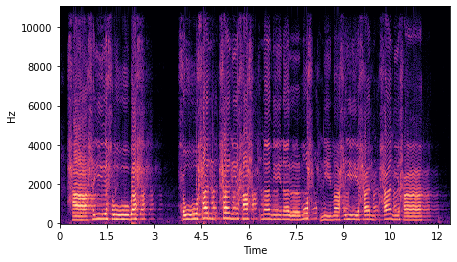

In [11]:
fig = plt.figure(figsize=(7,4))
fig.patch.set_facecolor('white')
ld.specshow(librosa.amplitude_to_db(np.abs(res.T),ref=np.max), hop_length=int(500/4),y_axis='linear', x_axis='time')
plt.savefig('my_stft_dft_recording1.png')

In [12]:
res.shape

(2188, 257)

## FFT dan STFT

In [13]:
def stft_fft(xn, window_size = None, hopsize= 512, window = 'hamming', fft_size = 512):
    total_samples = xn.shape[0]
    
    if window_size == None:
        window_size = fft_size
    
    if hopsize == None:
        hopsize = int(fft_size/4)

    
    # Getting window of size window_size
    window_fn = sp.signal.get_window(window, Nx=fft_size)
    
    start_index = 0 - hopsize
    end_index = window_size - hopsize
    
    stft_res = []
    
    
    counter = 0
    while start_index + hopsize <= total_samples - window_size:
        start_index = start_index + hopsize
        end_index = end_index + hopsize
        
        x_window = xn[start_index:end_index]
        
        
        # x_window is of window_size. Need to pad it to fft_size
        diff = fft_size - window_size
        
        if diff %2==0:
            
            x_window = np.pad(x_window, (int(diff/2), (int(diff/2))))
            
        else:
            
            x_window = np.pad(x_window, (int(diff/2), (int(diff/2)+1)))
        
        
        try:
        
            mult_window = x_window * window_fn
        
        except:
            print(start_index)
            print(end_index)
        
        dft_window = np.fft.fft(mult_window)[:int(fft_size/2)+1]
        
        stft_res.append(dft_window)
        
#         print(counter)
        counter+=1
    
    return np.array(stft_res)

In [14]:
res_stft = stft_fft(xn,window_size =500, hopsize = int(500/4))

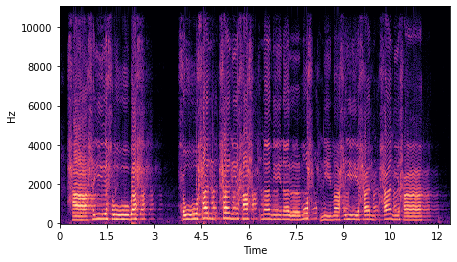

In [15]:
fig = plt.figure(figsize=(7,4))
fig.patch.set_facecolor('white')
ld.specshow(librosa.amplitude_to_db(np.abs(res_stft.T),ref=np.max), hop_length=int(500/4),y_axis='linear', x_axis='time')
plt.savefig('my_stft_fft_recording1.png')

In [16]:

res_stft.shape

(2188, 257)

## Implementasi Librosa

In [17]:
D_short = np.abs(librosa.stft(xn, hop_length=int(500/4), window='hamming', n_fft=512, win_length=500, center=False))

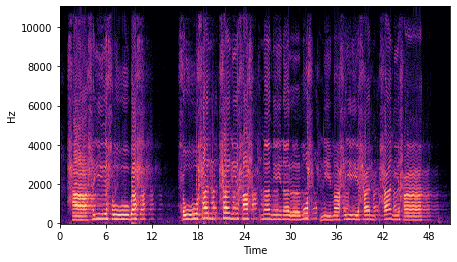

In [18]:
fig = plt.figure(figsize=(7,4))
fig.patch.set_facecolor('white')
ld.specshow(librosa.amplitude_to_db(D_short,ref=np.max), y_axis='linear', x_axis='time')
plt.savefig('librosa_stft_recording1.png')

In [19]:
D_short.shape

(257, 2188)

# 2 MFCC

In [20]:
def preemphasis(xn, alpha = 0.97):
    # Using pre-empaphases with a certain alpha
    pre_e_xn = np.zeros((xn.shape))
    
    pre_e_xn[0] = xn[0]
    
    pre_e_xn[1:] = xn[1:] - alpha * xn[:-1]
    
    return pre_e_xn

In [21]:
def get_mel_from_hertz(hertz):
    return 2595 * np.log10(1 + (hertz/ 700))

In [22]:
def get_hertz_from_mel(mel):
    return 700 * (10**(mel / 2595) - 1)

In [23]:
def get_power_spectrum(xn_mag, fft_size=2048):
    return (1/fft_size) * np.power(xn_mag, 2)

In [24]:
def get_triangle_function(prev_freq, cur_freq, nex_freq, filter_banks, bin_fb):
    
    # Ascending Triangle
    
    for freq in range(int(prev_freq), int(cur_freq)):
        
        filter_banks[bin_fb-1,freq] = (freq - prev_freq)/(cur_freq-prev_freq)
        
    # Descending Triangle
    
    for freq in range(int(cur_freq+1), int(nex_freq)):
        
        filter_banks[bin_fb-1, freq] = (nex_freq-freq)/(nex_freq-cur_freq)
        
    # Triangle Tip
    
    filter_banks[bin_fb-1, int(cur_freq)] = 1
    
    return filter_banks

In [25]:
def mel_filter_banks(xn_pow, sr, number_filters, fft_size=2048):
    min_mel = 0
    max_mel = get_mel_from_hertz(sr/2)
    
    mel_freq_points = np.linspace(min_mel, max_mel, num=number_filters+2)
    hertz_freq_points = get_hertz_from_mel(mel_freq_points)
    
    corresponding_bins_hertz_points = np.floor((fft_size + 1) * hertz_freq_points / sr)
    
    # Filter banks have to be of shape number_filters * (fft_size/2) + 1
    filter_banks = np.zeros((number_filters, int(fft_size/2)+1))
    
    for bin_fb in range(1, number_filters+1):
        
        prev_bin = corresponding_bins_hertz_points[bin_fb-1]
        current_bin = corresponding_bins_hertz_points[bin_fb]
        next_bin = corresponding_bins_hertz_points[bin_fb+1]
        
        # Use the triangle function to get the values of the banks
        
        filter_banks = get_triangle_function(prev_bin, current_bin, next_bin, filter_banks, bin_fb)
        
    return filter_banks

In [26]:
def get_delta_values(x):
    delta_x = np.zeros(shape=x.shape)
    for i in range(1,x.shape[1]-1):
        prev_val = x[:,i-1]
        next_val = x[:,i+1]
        
        delta_x[:,i]  = (next_val - prev_val)/2
    
    return delta_x

In [27]:

def mfcc(xn, sr, number_filters, window_size = 500, hopsize=int(500/4), fft_size=512):
    
    # Pre-emphasis
    
    xn = preemphasis(xn)
    
    # Getting the STFT
        
    xn_stft = stft(xn, window_size= window_size, hopsize=hopsize, fft_size=fft_size)
    
    # Getting the Magnitude of the STFT
    
    xn_mag = np.abs(xn_stft)
    
    # Evaluating the Power spectrum for the magnitude
    
    xn_pow = get_power_spectrum(xn_mag, fft_size=fft_size)
    
    # To get the mel filter banks
    
    filter_banks = mel_filter_banks(xn_pow, sr, number_filters, fft_size=fft_size)
    
    machine_epsilon =  2.22044604925e-16
    
    filter_banks[filter_banks==0] = machine_epsilon
    
    
    # Multiply the filter_banks with the power spectrum
    
    filter_banks_res = np.dot(filter_banks, xn_pow.T)
    
    # Taking the log and the inverse DFT
    
    filter_banks_res = filter_banks_res + machine_epsilon
    
    log_filter_bank = np.log(filter_banks_res)
    
    idft = sp.fftpack.dct(log_filter_bank)
    
    # First 12 MFCC Values
    
    first_12 = idft[:12,:]
    
    # delta and delta-delta coefficients
    
    delta = get_delta_values(idft)
    
    delta_delta = get_delta_values(delta)
    
    # Getting Energy values of delta and delta-delta coefficients
    
    first_12_delta = delta[:12,:]
    
    first_12_delta_delta = delta_delta[:12,:]
    
    
    # Energy of the Cepstrum frame. Read from - http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.596.8754&rep=rep1&type=pdf
    
    energy = np.sqrt(np.sum(np.power(first_12,2),axis=0)).reshape(1,-1)
    
    energy_delta = np.sqrt(np.sum(np.power(first_12_delta,2),axis=0)).reshape(1,-1)
    
    energy_delta_delta = np.sqrt(np.sum(np.power(first_12_delta_delta,2),axis=0)).reshape(1,-1)
    
    return np.vstack((energy, energy_delta, energy_delta_delta, first_12, first_12_delta, first_12_delta_delta)), filter_banks

In [28]:
print(xn, sr)

[-0.00093662  0.00154463  0.00256301 ... -0.00079306 -0.00070373
  0.        ] 22050


In [29]:
mfcc_xn, filter_banks = mfcc(xn, sr, 40)

In [30]:
mfcc_xn

array([[ 1.53735342e+05,  3.74115510e+03,  5.38104321e+03, ...,
         1.94082644e+02,  1.80634005e+02,  1.19989981e+02],
       [ 0.00000000e+00,  7.51844550e+04,  4.93266414e+03, ...,
         1.16857082e+02,  7.68653040e+01,  0.00000000e+00],
       [ 0.00000000e+00,  2.46633207e+03,  3.66551540e+04, ...,
         9.48593831e+01,  5.84285408e+01,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  4.64071334e+02, -7.58784802e+03, ...,
         1.65924236e+00,  1.79027330e+00,  0.00000000e+00],
       [ 0.00000000e+00,  4.60032267e+02, -6.94487825e+03, ...,
         5.82382481e+00, -2.78129582e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.29751966e+02, -7.71823840e+03, ...,
        -6.87454442e-01, -7.64648356e+00,  0.00000000e+00]])

In [31]:
mfcc_xn.T.shape

(2188, 39)

In [32]:
filter_banks.shape

(40, 257)

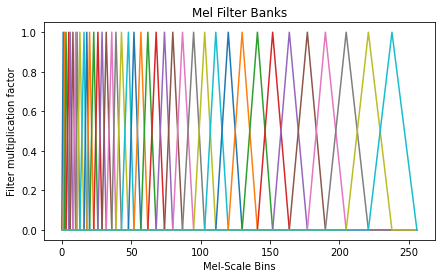

In [33]:
fig = plt.figure(figsize=(7,4))
fig.patch.set_facecolor('white')
plt.plot(filter_banks.T)
plt.ylabel("Filter multiplication factor")
plt.xlabel("Mel-Scale Bins")
plt.title("Mel Filter Banks")
plt.savefig("mel_filter_banks.png")
plt.show()

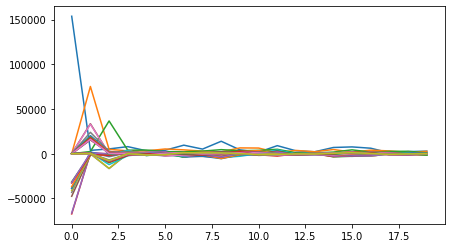

In [34]:
fig = plt.figure(figsize=(7,4))
fig.patch.set_facecolor('white')
plt.plot(mfcc_xn.T[:20])
plt.show()

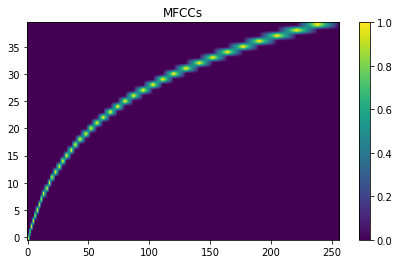

In [35]:
fig, ax = plt.subplots(figsize=(7, 4))
fig.patch.set_facecolor('white')

image = ax.imshow(filter_banks, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(image, ax=ax)

plt.title('MFCCs')
plt.show()

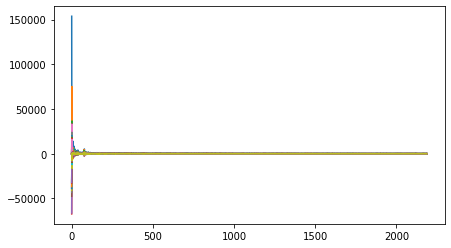

In [36]:
fig = plt.figure(figsize=(7,4))
fig.patch.set_facecolor('white')
plt.plot(mfcc_xn.T)
plt.show()

## TES MFCC librosa

In [37]:
audio_file = '../Dataset/01.Ha\'/Ha\'_M1_1.wav'

In [38]:
y , sr = librosa.load(audio_file)
print(y, sr)

[ 0.          0.          0.         ... -0.00265897 -0.00145254
 -0.00027109] 22050


In [39]:
print('y shape = {} and sr = {}'.format(y.shape, sr))

y shape = (264600,) and sr = 22050


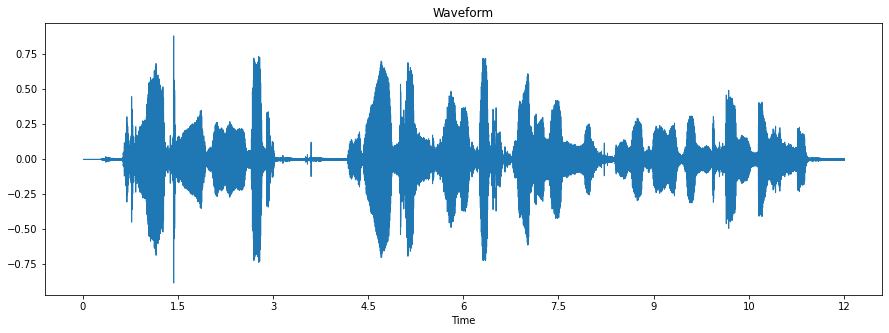

In [40]:
# Visualisasi Sinyal Audio
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('white')
# plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

In [41]:
y_preemphasized = librosa.effects.preemphasis(y)
print(y_preemphasized)

[ 0.          0.          0.         ... -0.00077838  0.00112665
  0.00113787]


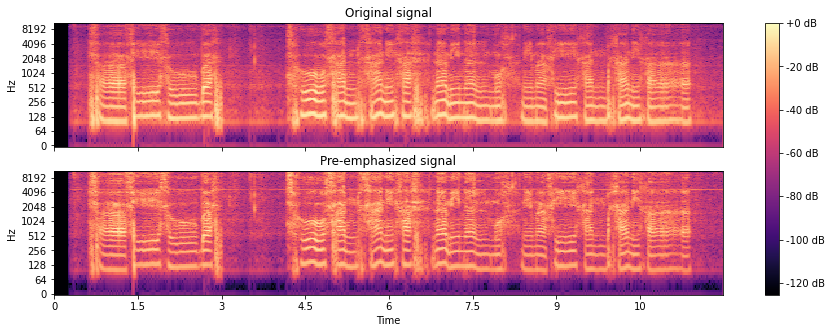

In [42]:
S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max, top_db=None)
S_preemph = librosa.amplitude_to_db(np.abs(librosa.stft(y_preemphasized)), ref=np.max, top_db=None)
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(15,5))
fig.patch.set_facecolor('white')
librosa.display.specshow(S_orig, y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Original signal')
ax[0].label_outer()
img = librosa.display.specshow(S_preemph, y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Pre-emphasized signal')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [43]:
y_filt_1, zf = librosa.effects.preemphasis(y[:1000], return_zf=True)
y_filt_2, zf = librosa.effects.preemphasis(y[1000:], zi=zf, return_zf=True)
np.allclose(y_preemphasized, np.concatenate([y_filt_1, y_filt_2]))

True

In [44]:
frame_length = 2048
hop_length = 512
frames = librosa.util.frame(y_preemphasized, frame_length=frame_length, hop_length=hop_length)


In [45]:
# Inisialisasi window function (jendela)
window = np.hamming(frame_length)


In [46]:
# Terapkan windowing pada setiap frame
frames = frames * window[:, np.newaxis]


In [47]:
y_normalized = librosa.util.normalize(y_preemphasized)
print(y_normalized)
print(y_normalized.shape)


[ 0.          0.          0.         ... -0.0039581   0.0057291
  0.00578616]
(264600,)


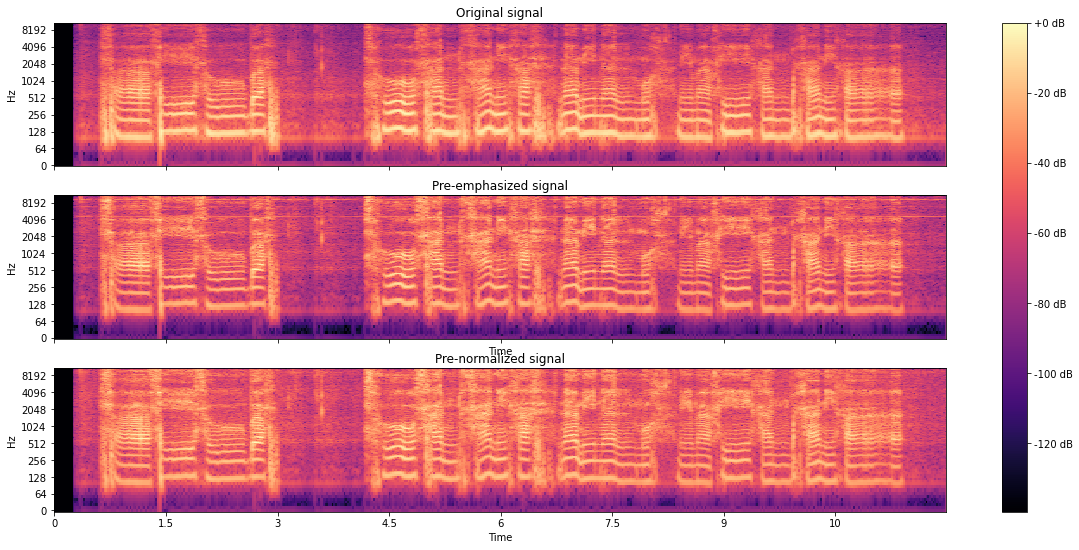

In [48]:
S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max, top_db=None)
S_preemph = librosa.amplitude_to_db(np.abs(librosa.stft(y_preemphasized)), ref=np.max, top_db=None)
S_normalized = librosa.amplitude_to_db(np.abs(librosa.stft(y_normalized)), ref=np.max, top_db=None)
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(20,9))
fig.patch.set_facecolor('white')
librosa.display.specshow(S_orig, y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Original signal')
ax[0].label_outer()
img = librosa.display.specshow(S_preemph, y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Pre-emphasized signal')
img = librosa.display.specshow(S_normalized, y_axis='log', x_axis='time', ax=ax[2])
ax[2].set(title='Pre-normalized signal')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [49]:
melfb = librosa.filters.mel(sr=22050, n_fft=2048)
print(melfb)
print(melfb.shape)

[[0.         0.01618285 0.03236571 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00026052 0.00013026 0.        ]]
(128, 1025)


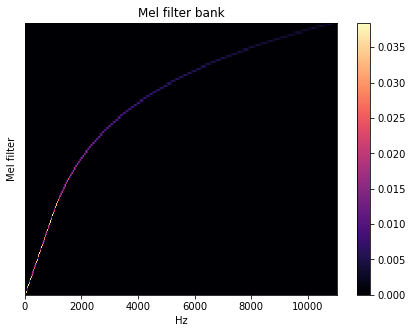

In [50]:
fig, ax = plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
img = librosa.display.specshow(melfb, x_axis='linear', ax=ax)
ax.set(ylabel='Mel filter', title='Mel filter bank')
fig.colorbar(img, ax=ax)

In [51]:
S = np.abs(librosa.stft(y))
print(S)
print(S.shape)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.2557223e-02
  2.6017837e-02 8.0745548e-02]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 9.9163204e-03
  1.1644944e-02 6.1857544e-02]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.5025186e-03
  3.6581533e-03 6.0724948e-02]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.4638036e-08
  5.4958896e-06 1.3220747e-04]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.7995862e-08
  5.5047180e-06 1.3199777e-04]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.4789858e-08
  5.5058345e-06 1.3190838e-04]]
(1025, 517)


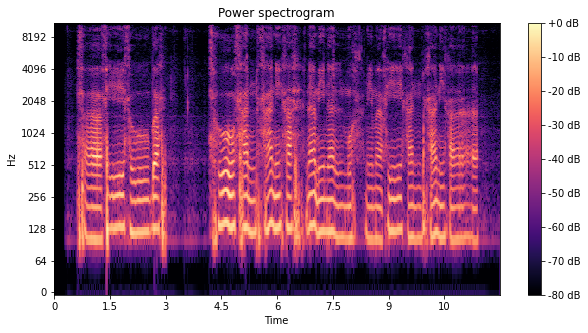

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
fig.patch.set_facecolor('white')
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                                                        y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [53]:
S_mel1 = librosa.feature.melspectrogram(y=y, sr=sr)
print(S_mel1)
print(S_mel1.shape)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.2690218e-06
  2.9161658e-06 3.5183164e-04]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.0811221e-05
  2.6528402e-05 6.0347619e-04]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.0523579e-03
  4.7301021e-03 5.3464882e-03]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 8.6655291e-06
  3.3475189e-06 1.8119306e-06]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.7725384e-06
  9.8454052e-07 4.8365337e-07]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.4053772e-07
  4.0774569e-08 3.5594795e-08]]
(128, 517)


In [54]:
D = np.abs(librosa.stft(y))**2
S_mel2 = librosa.feature.melspectrogram(S=D, sr=sr)
print(S_mel2)
print(S_mel2.shape)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.2690218e-06
  2.9161658e-06 3.5183164e-04]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.0811221e-05
  2.6528402e-05 6.0347619e-04]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.0523579e-03
  4.7301021e-03 5.3464882e-03]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 8.6655291e-06
  3.3475189e-06 1.8119306e-06]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.7725384e-06
  9.8454052e-07 4.8365337e-07]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.4053772e-07
  4.0774569e-08 3.5594795e-08]]
(128, 517)


In [55]:
#cek apakah sama
np.allclose(S_mel1,S_mel2)

True

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

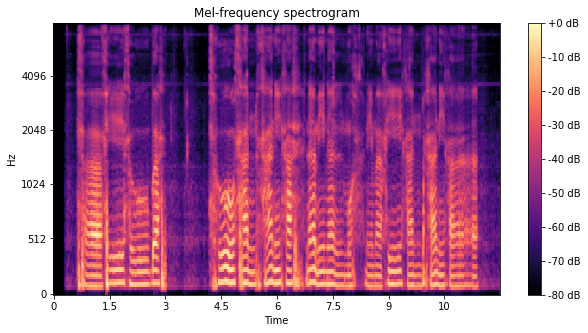

In [56]:
fig, ax = plt.subplots(figsize=(10,5))
fig.patch.set_facecolor('white')
S_dB = librosa.power_to_db(S_mel1, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [57]:
librosa_mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S_mel2), n_mfcc=13)
print(librosa_mfcc)
print(librosa_mfcc.shape)

[[-5.8868433e+02 -5.8868433e+02 -5.8868433e+02 ... -4.4796240e+02
  -4.4937338e+02 -4.5030643e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  8.3800972e+01
   8.7521660e+01  9.2038155e+01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.6763735e+00
  -1.4837027e-02  4.3385458e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.1789918e+00
  -7.4504385e+00  7.2812879e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  4.0085263e+00
   1.6347671e+00  5.3226237e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.1689359e-01
  -3.1214175e+00 -7.9758596e-01]]
(13, 517)


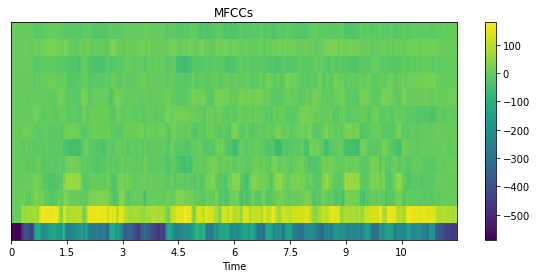

In [58]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa_mfcc, x_axis="time", cmap="viridis")
plt.colorbar()
plt.title("MFCCs")
plt.show()